# Jersey City Citi Bike Data Exploration

A comprehensive analysis of 6+ million trips from Jersey City and Hoboken's bike share system (2015-2025).

**What makes JC interesting:**
- Waterfront commuter corridor (PATH trains to NYC)
- Distinct from NYC - different demographics, patterns
- Smaller system = easier to see individual station patterns
- COVID recovery story
- E-bike adoption

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import folium
from folium.plugins import MarkerCluster

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Connect to DuckDB
con = duckdb.connect()

# Path to JC data
JC_DATA = '../data/jc/processed/*.parquet'
NYC_DATA = '../data/processed/*.parquet'

print('Data loaded!')

Data loaded!


/Users/davidpiegaro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


---
## 1. Data Overview & Quality Check

In [2]:
# Basic stats
overview = con.execute(f'''
    SELECT
        COUNT(*) as total_trips,
        COUNT(DISTINCT start_station_id) as unique_start_stations,
        COUNT(DISTINCT end_station_id) as unique_end_stations,
        COUNT(DISTINCT start_station_name) as unique_start_names,
        MIN(started_at) as first_trip,
        MAX(started_at) as last_trip,
        ROUND(AVG(duration_sec) / 60, 1) as avg_duration_min,
        ROUND(MEDIAN(duration_sec) / 60, 1) as median_duration_min,
        SUM(CASE WHEN member_casual = 'member' THEN 1 ELSE 0 END) as member_trips,
        SUM(CASE WHEN member_casual = 'casual' THEN 1 ELSE 0 END) as casual_trips
    FROM "{JC_DATA}"
''').fetchdf()

print("=" * 60)
print("JERSEY CITY CITI BIKE - DATA OVERVIEW")
print("=" * 60)
print(f"Total Trips:           {overview['total_trips'].values[0]:,}")
print(f"Date Range:            {overview['first_trip'].values[0]} to {overview['last_trip'].values[0]}")
print(f"Unique Stations:       {overview['unique_start_names'].values[0]}")
print(f"Avg Duration:          {overview['avg_duration_min'].values[0]} minutes")
print(f"Median Duration:       {overview['median_duration_min'].values[0]} minutes")
print(f"Member Trips:          {overview['member_trips'].values[0]:,} ({100*overview['member_trips'].values[0]/overview['total_trips'].values[0]:.1f}%)")
print(f"Casual Trips:          {overview['casual_trips'].values[0]:,} ({100*overview['casual_trips'].values[0]/overview['total_trips'].values[0]:.1f}%)")

JERSEY CITY CITI BIKE - DATA OVERVIEW
Total Trips:           6,049,509
Date Range:            2015-09-21T14:55:59.000000 to 2025-11-30T23:55:32.867000
Unique Stations:       454
Avg Duration:          10.8 minutes
Median Duration:       6.7 minutes
Member Trips:          4,586,567.0 (75.8%)
Casual Trips:          1,462,448.0 (24.2%)


In [3]:
# Data quality: match types
quality = con.execute(f'''
    SELECT
        start_match_type,
        COUNT(*) as trips,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) as pct
    FROM "{JC_DATA}"
    GROUP BY 1
    ORDER BY 2 DESC
''').fetchdf()

print("\nStation Match Quality:")
print(quality.to_string(index=False))


Station Match Quality:
start_match_type   trips   pct
       unmatched 4380931 72.42
       crosswalk 1541921 25.49
           ghost  126657  2.09


In [4]:
# Schema sample
sample = con.execute(f'''
    SELECT * FROM "{JC_DATA}" LIMIT 3
''').fetchdf()
print("\nSample Records:")
sample.T


Sample Records:


,0,1,2
ride_id,31e945f9ccdc818a1894e95072766804,bdde5650fe77ffe1d3e6ada7d7275795,7f489c6e98d79420e3ab01d04362bae7
started_at,2015-09-21 14:55:59,2015-09-21 14:56:14,2015-09-21 14:58:35
ended_at,2015-09-21 15:00:50,2015-09-21 15:09:21,2015-09-21 15:06:32
duration_sec,290,786,477
start_station_id,3742e2ab-6cd0-40cf-846a-72cbe637afe1,3742e2ab-6cd0-40cf-846a-72cbe637afe1,66dd7b37-0aca-11e7-82f6-3863bb44ef7c
start_station_name,Exchange Pl,Exchange Pl,Hamilton Park
start_lat,40.716366,40.716366,40.727596
start_lon,-74.034344,-74.034344,-74.044247
end_station_id,66dd5a42-0aca-11e7-82f6-3863bb44ef7c,3742e2ab-6cd0-40cf-846a-72cbe637afe1,66dd7b37-0aca-11e7-82f6-3863bb44ef7c
end_station_name,Warren St,Exchange Pl,Hamilton Park


---
## 2. Growth Over Time

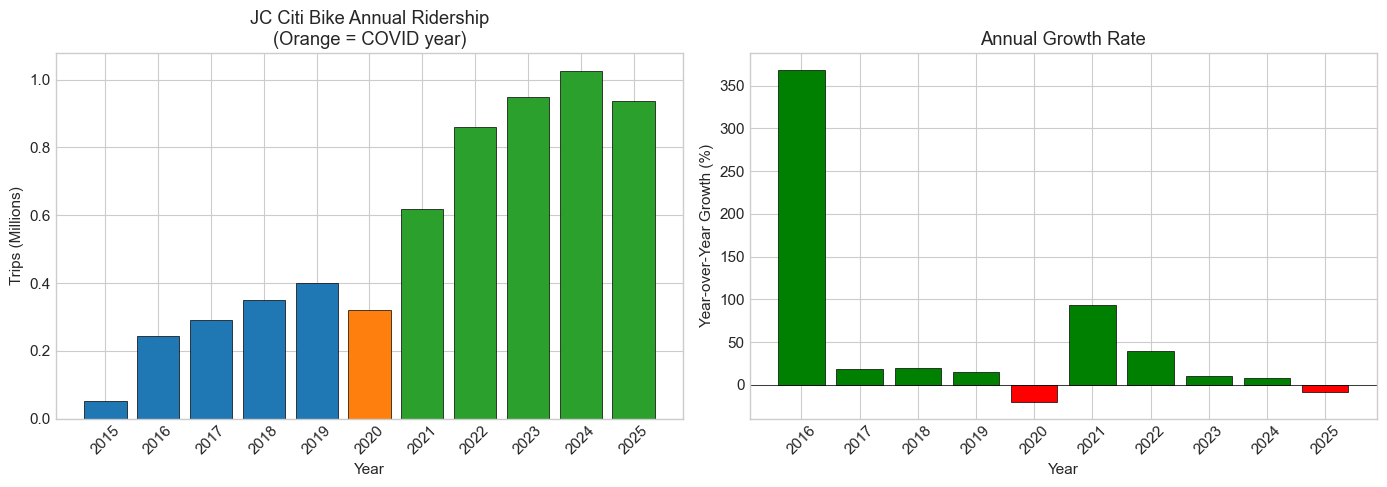


Yearly Summary:
 year   trips  days_with_trips  avg_daily_trips  stations_used  yoy_growth
 2015   52275              102            513.0             35         NaN
 2016  244902              362            677.0             51  368.487805
 2017  290951              361            806.0             55   18.803031
 2018  349277              365            957.0             58   20.046675
 2019  399939              365           1096.0             53   14.504820
 2020  319757              366            874.0             52  -20.048557
 2021  619468              364           1702.0             86   93.730864
 2022  861828              365           2361.0             83   39.123893
 2023  947571              365           2596.0            347    9.948969
 2024 1026925              366           2806.0            202    8.374465
 2025  936616              334           2804.0             98   -8.794118


In [5]:
# Annual growth
yearly = con.execute(f'''
    SELECT
        EXTRACT(YEAR FROM started_at) as year,
        COUNT(*) as trips,
        COUNT(DISTINCT DATE(started_at)) as days_with_trips,
        ROUND(COUNT(*) / COUNT(DISTINCT DATE(started_at)), 0) as avg_daily_trips,
        COUNT(DISTINCT start_station_name) as stations_used
    FROM "{JC_DATA}"
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total trips by year
colors = ['#1f77b4' if y < 2020 else '#ff7f0e' if y == 2020 else '#2ca02c' for y in yearly['year']]
axes[0].bar(yearly['year'], yearly['trips'] / 1e6, color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Trips (Millions)')
axes[0].set_title('JC Citi Bike Annual Ridership\n(Orange = COVID year)')
axes[0].set_xticks(yearly['year'])
axes[0].set_xticklabels(yearly['year'].astype(int), rotation=45)

# YoY growth rate
yearly['yoy_growth'] = yearly['trips'].pct_change() * 100
colors2 = ['green' if g > 0 else 'red' for g in yearly['yoy_growth'].fillna(0)]
axes[1].bar(yearly['year'][1:], yearly['yoy_growth'][1:], color=colors2[1:], edgecolor='black', linewidth=0.5)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Year-over-Year Growth (%)')
axes[1].set_title('Annual Growth Rate')
axes[1].set_xticks(yearly['year'][1:])
axes[1].set_xticklabels(yearly['year'][1:].astype(int), rotation=45)

plt.tight_layout()
plt.show()

print("\nYearly Summary:")
print(yearly.to_string(index=False))

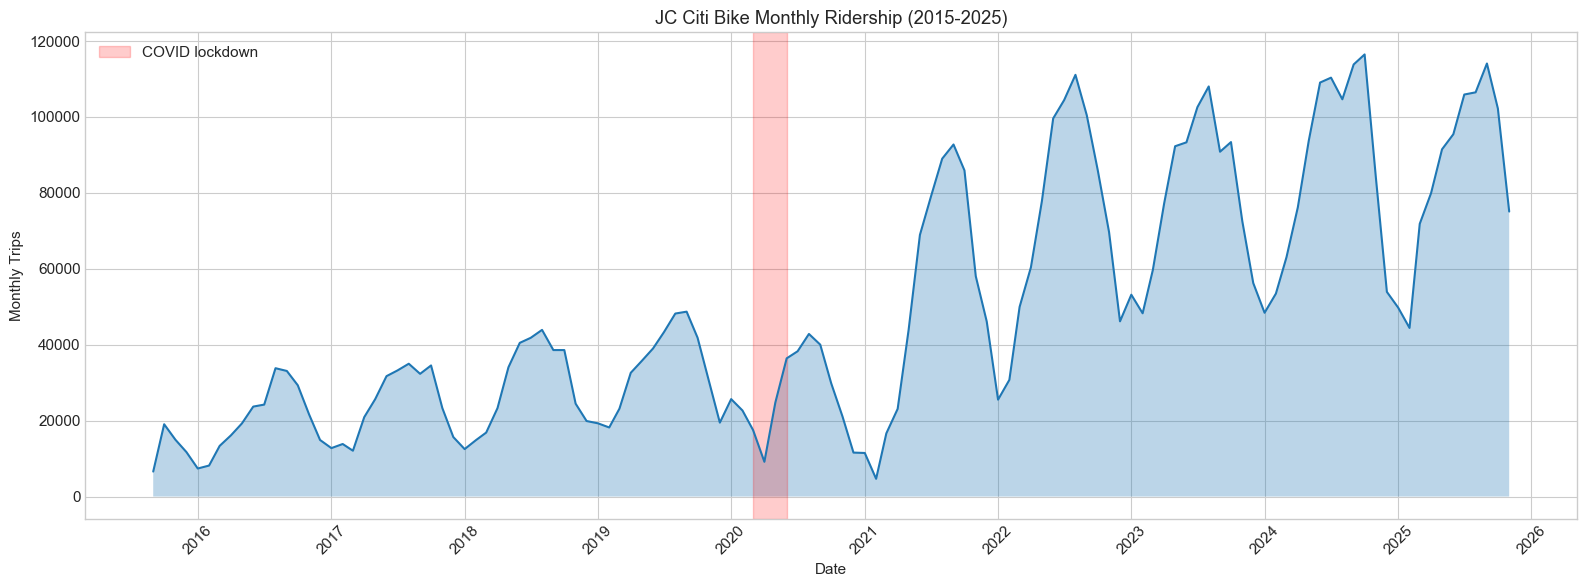

In [6]:
# Monthly trends - full time series
monthly = con.execute(f'''
    SELECT
        DATE_TRUNC('month', started_at) as month,
        COUNT(*) as trips
    FROM "{JC_DATA}"
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

monthly['month'] = pd.to_datetime(monthly['month'])

fig, ax = plt.subplots(figsize=(16, 6))
ax.fill_between(monthly['month'], monthly['trips'], alpha=0.3)
ax.plot(monthly['month'], monthly['trips'], linewidth=1.5)

# Mark COVID period
ax.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-06-01'), 
           alpha=0.2, color='red', label='COVID lockdown')

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Trips')
ax.set_title('JC Citi Bike Monthly Ridership (2015-2025)')
ax.legend()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
## 3. Seasonality & Weather Patterns

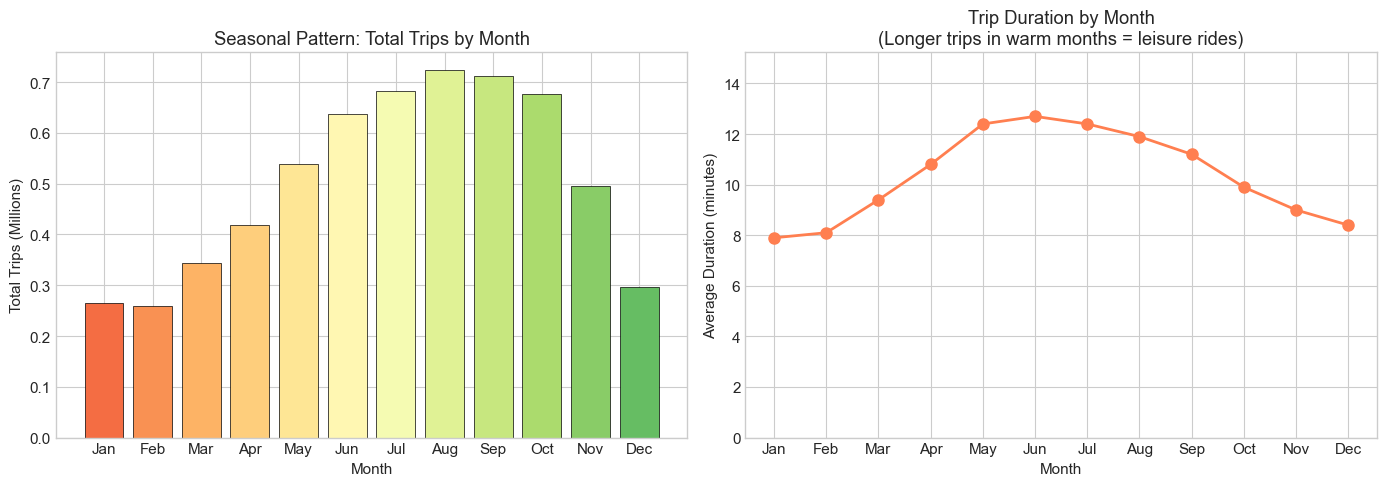

Peak month: Aug (722,986 trips)
Trough month: Feb (259,272 trips)
Peak/Trough ratio: 2.8x


In [7]:
# Seasonality by month of year
seasonality = con.execute(f'''
    SELECT
        EXTRACT(MONTH FROM started_at) as month_num,
        COUNT(*) as trips,
        ROUND(AVG(duration_sec) / 60, 1) as avg_duration
    FROM "{JC_DATA}"
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trip volume by month
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 12))
bars = axes[0].bar(month_names, seasonality['trips'] / 1e6, color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Trips (Millions)')
axes[0].set_title('Seasonal Pattern: Total Trips by Month')

# Average duration by month
axes[1].plot(month_names, seasonality['avg_duration'], 'o-', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Duration (minutes)')
axes[1].set_title('Trip Duration by Month\n(Longer trips in warm months = leisure rides)')
axes[1].set_ylim(0, max(seasonality['avg_duration']) * 1.2)

plt.tight_layout()
plt.show()

peak_month = month_names[seasonality['trips'].idxmax()]
trough_month = month_names[seasonality['trips'].idxmin()]
print(f"Peak month: {peak_month} ({seasonality['trips'].max():,} trips)")
print(f"Trough month: {trough_month} ({seasonality['trips'].min():,} trips)")
print(f"Peak/Trough ratio: {seasonality['trips'].max() / seasonality['trips'].min():.1f}x")

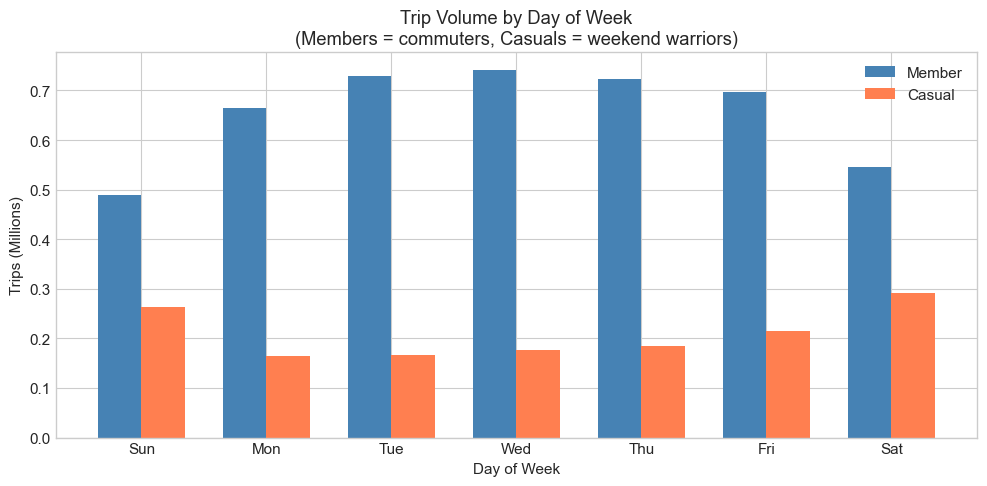

In [8]:
# Day of week patterns
dow = con.execute(f'''
    SELECT
        EXTRACT(DOW FROM started_at) as dow,
        member_casual,
        COUNT(*) as trips
    FROM "{JC_DATA}"
    GROUP BY 1, 2
    ORDER BY 1
''').fetchdf()

dow_pivot = dow.pivot(index='dow', columns='member_casual', values='trips').fillna(0)
dow_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(7)
width = 0.35

bars1 = ax.bar(x - width/2, dow_pivot['member'] / 1e6, width, label='Member', color='steelblue')
bars2 = ax.bar(x + width/2, dow_pivot['casual'] / 1e6, width, label='Casual', color='coral')

ax.set_xlabel('Day of Week')
ax.set_ylabel('Trips (Millions)')
ax.set_title('Trip Volume by Day of Week\n(Members = commuters, Casuals = weekend warriors)')
ax.set_xticks(x)
ax.set_xticklabels(dow_names)
ax.legend()

plt.tight_layout()
plt.show()

---
## 4. Hourly Patterns - The Commuter Signature

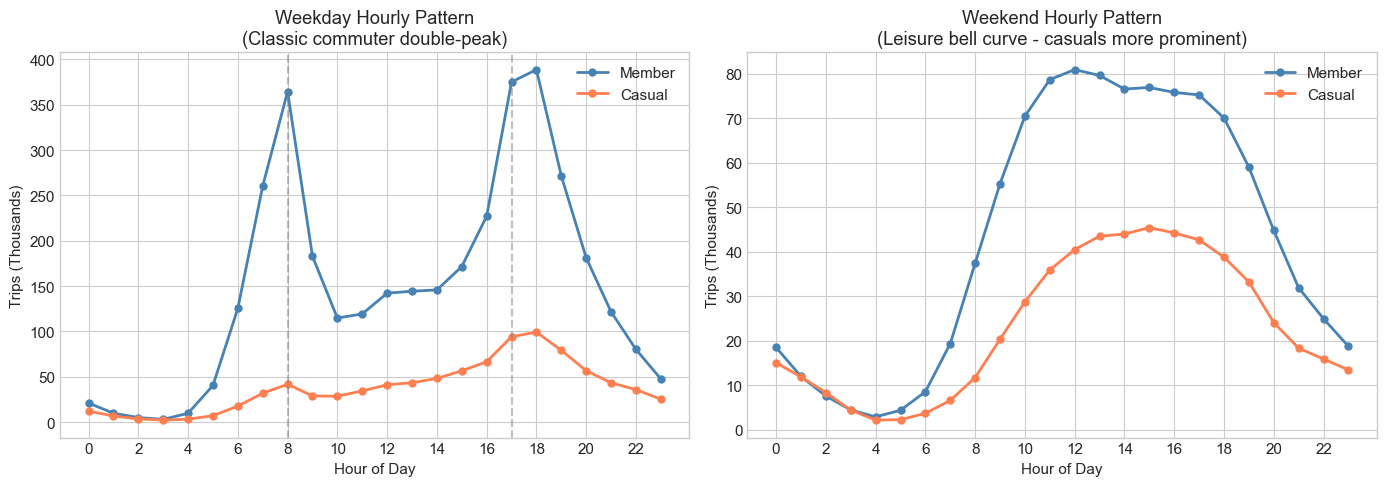

In [9]:
# Hourly patterns by user type and day type
hourly = con.execute(f'''
    SELECT
        EXTRACT(HOUR FROM started_at) as hour,
        member_casual,
        CASE WHEN EXTRACT(DOW FROM started_at) IN (0, 6) THEN 'Weekend' ELSE 'Weekday' END as day_type,
        COUNT(*) as trips
    FROM "{JC_DATA}"
    GROUP BY 1, 2, 3
    ORDER BY 1
''').fetchdf()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weekday pattern
weekday = hourly[hourly['day_type'] == 'Weekday']
for user_type, color in [('member', 'steelblue'), ('casual', 'coral')]:
    data = weekday[weekday['member_casual'] == user_type]
    axes[0].plot(data['hour'], data['trips'] / 1000, 'o-', label=user_type.title(), 
                 linewidth=2, markersize=5, color=color)

axes[0].axvline(x=8, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(x=17, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Trips (Thousands)')
axes[0].set_title('Weekday Hourly Pattern\n(Classic commuter double-peak)')
axes[0].legend()
axes[0].set_xticks(range(0, 24, 2))

# Weekend pattern
weekend = hourly[hourly['day_type'] == 'Weekend']
for user_type, color in [('member', 'steelblue'), ('casual', 'coral')]:
    data = weekend[weekend['member_casual'] == user_type]
    axes[1].plot(data['hour'], data['trips'] / 1000, 'o-', label=user_type.title(), 
                 linewidth=2, markersize=5, color=color)

axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Trips (Thousands)')
axes[1].set_title('Weekend Hourly Pattern\n(Leisure bell curve - casuals more prominent)')
axes[1].legend()
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

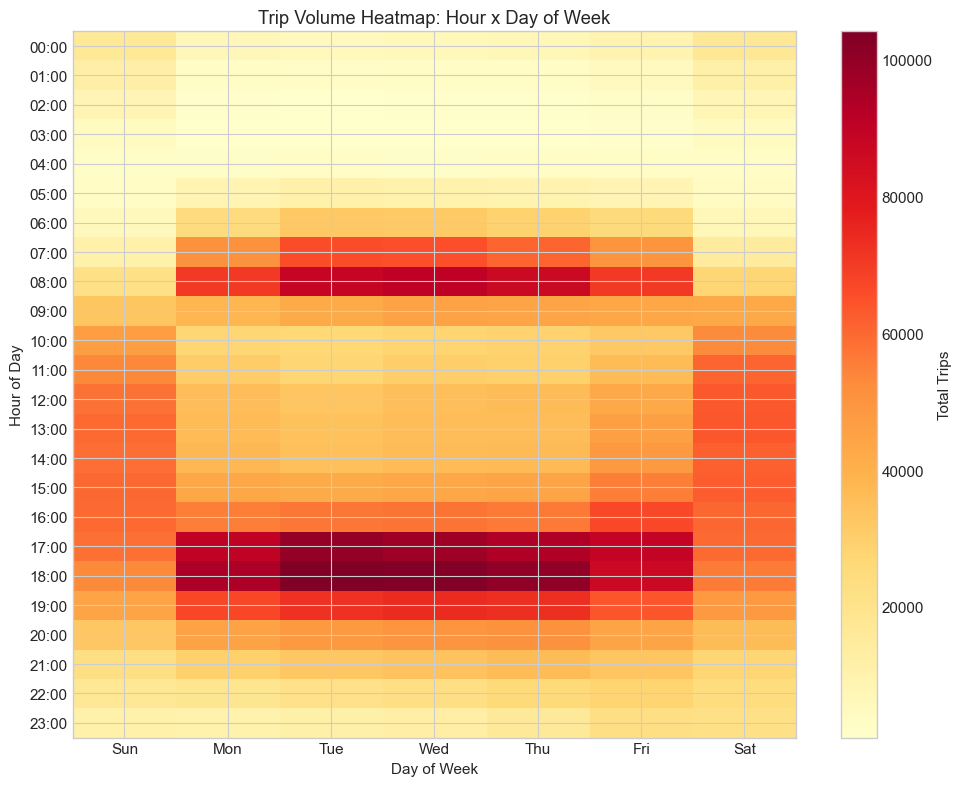

In [10]:
# Heatmap: hour x day of week
heatmap_data = con.execute(f'''
    SELECT
        EXTRACT(DOW FROM started_at) as dow,
        EXTRACT(HOUR FROM started_at) as hour,
        COUNT(*) as trips
    FROM "{JC_DATA}"
    GROUP BY 1, 2
''').fetchdf()

pivot = heatmap_data.pivot(index='hour', columns='dow', values='trips').fillna(0)
pivot.columns = dow_names

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(pivot.values, aspect='auto', cmap='YlOrRd')

ax.set_xticks(range(7))
ax.set_xticklabels(dow_names)
ax.set_yticks(range(24))
ax.set_yticklabels([f'{h:02d}:00' for h in range(24)])
ax.set_xlabel('Day of Week')
ax.set_ylabel('Hour of Day')
ax.set_title('Trip Volume Heatmap: Hour x Day of Week')

plt.colorbar(im, ax=ax, label='Total Trips')
plt.tight_layout()
plt.show()

---
## 5. Top Stations & Routes

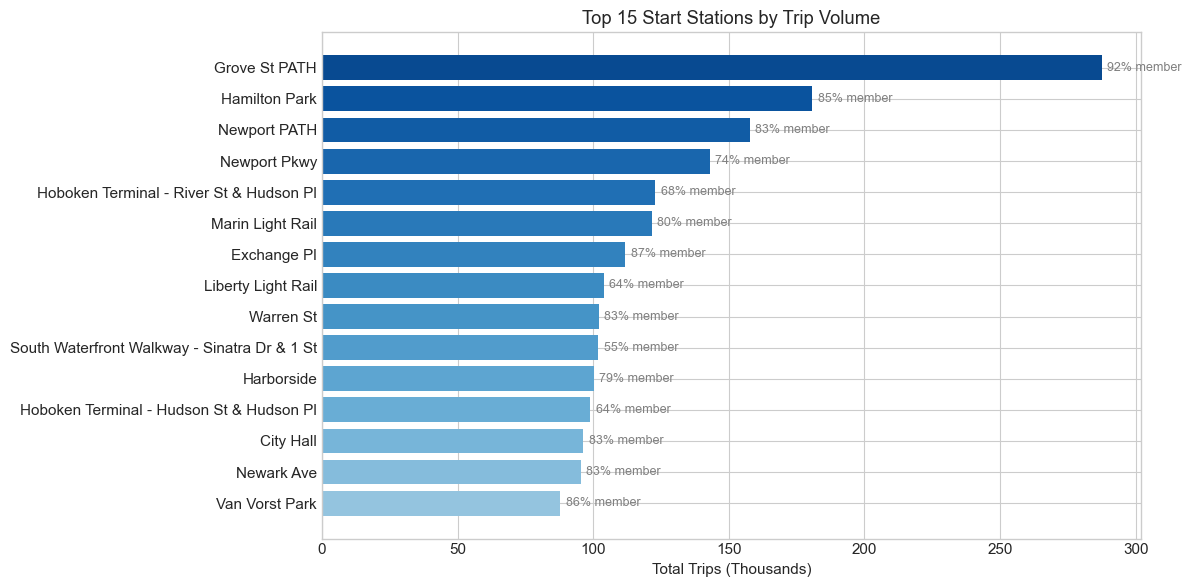


Top 15 Stations Detail:
                          start_station_name  total_trips  member_pct  avg_duration_min     lat      lon
                               Grove St PATH       287438        91.6               7.5 40.7194 -74.0431
                               Hamilton Park       180761        85.4               9.5 40.7276 -74.0442
                                Newport PATH       157760        83.0              11.4 40.7272 -74.0338
                                Newport Pkwy       142990        73.6              16.1 40.7287 -74.0321
     Hoboken Terminal - River St & Hudson Pl       122883        68.1               9.2 40.7361 -74.0291
                            Marin Light Rail       121607        79.8              12.0 40.7146 -74.0428
                                 Exchange Pl       111783        86.7               9.9 40.7164 -74.0343
                          Liberty Light Rail       103970        63.7              23.3 40.7112 -74.0557
                              

In [11]:
# Top 15 start stations
top_stations = con.execute(f'''
    SELECT
        start_station_name,
        COUNT(*) as total_trips,
        ROUND(100.0 * SUM(CASE WHEN member_casual = 'member' THEN 1 ELSE 0 END) / COUNT(*), 1) as member_pct,
        ROUND(AVG(duration_sec) / 60, 1) as avg_duration_min,
        ROUND(start_lat, 4) as lat,
        ROUND(start_lon, 4) as lon
    FROM "{JC_DATA}"
    WHERE start_station_name IS NOT NULL
    GROUP BY 1, start_lat, start_lon
    ORDER BY 2 DESC
    LIMIT 15
''').fetchdf()

fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_stations)))
bars = ax.barh(range(len(top_stations)), top_stations['total_trips'] / 1000, color=colors[::-1])
ax.set_yticks(range(len(top_stations)))
ax.set_yticklabels(top_stations['start_station_name'])
ax.invert_yaxis()
ax.set_xlabel('Total Trips (Thousands)')
ax.set_title('Top 15 Start Stations by Trip Volume')

# Add member % annotation
for i, (trips, member_pct) in enumerate(zip(top_stations['total_trips'], top_stations['member_pct'])):
    ax.annotate(f'{member_pct:.0f}% member', xy=(trips/1000 + 2, i), va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

print("\nTop 15 Stations Detail:")
print(top_stations.to_string(index=False))

In [12]:
# Top routes (start -> end)
top_routes = con.execute(f'''
    SELECT
        start_station_name || ' -> ' || end_station_name as route,
        start_station_name,
        end_station_name,
        COUNT(*) as trips,
        CASE WHEN start_station_name = end_station_name THEN 'Round Trip' ELSE 'One Way' END as trip_type,
        ROUND(AVG(duration_sec) / 60, 1) as avg_duration
    FROM "{JC_DATA}"
    WHERE start_station_name IS NOT NULL AND end_station_name IS NOT NULL
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
    LIMIT 20
''').fetchdf()

print("Top 20 Routes:")
print(top_routes[['route', 'trips', 'trip_type', 'avg_duration']].to_string(index=False))

Top 20 Routes:
                                                                 route  trips  trip_type  avg_duration
                                        Hamilton Park -> Grove St PATH  49239    One Way           5.5
                                        Grove St PATH -> Hamilton Park  37840    One Way           5.8
                                         Brunswick St -> Grove St PATH  33672    One Way           4.9
                                     Marin Light Rail -> Grove St PATH  31928    One Way           4.4
                                     Grove St PATH -> Marin Light Rail  31674    One Way           4.8
                              Liberty Light Rail -> Liberty Light Rail  28467 Round Trip          52.6
                                          Dixon Mills -> Grove St PATH  25622    One Way           3.4
                                       Van Vorst Park -> Grove St PATH  24654    One Way           3.8
Hoboken Terminal - Hudson St & Hudson Pl -> Hoboken Ave at

In [13]:
# Round trip analysis
round_trips = con.execute(f'''
    SELECT
        EXTRACT(YEAR FROM started_at) as year,
        COUNT(*) as total_trips,
        SUM(CASE WHEN start_station_name = end_station_name THEN 1 ELSE 0 END) as round_trips,
        ROUND(100.0 * SUM(CASE WHEN start_station_name = end_station_name THEN 1 ELSE 0 END) / COUNT(*), 2) as round_trip_pct
    FROM "{JC_DATA}"
    WHERE start_station_name IS NOT NULL AND end_station_name IS NOT NULL
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

print("Round Trip Analysis by Year:")
print(round_trips.to_string(index=False))
print(f"\nOverall round trip rate: {round_trips['round_trips'].sum() / round_trips['total_trips'].sum() * 100:.2f}%")

Round Trip Analysis by Year:
 year  total_trips  round_trips  round_trip_pct
 2015        52275       3368.0            6.44
 2016       244902      12628.0            5.16
 2017       290951      11738.0            4.03
 2018       349277      13214.0            3.78
 2019       399939      16736.0            4.18
 2020       319757      49386.0           15.44
 2021       619468      57008.0            9.20
 2022       861828      54014.0            6.27
 2023       947571      42747.0            4.51
 2024      1026925      39931.0            3.89
 2025       936616      32996.0            3.52

Overall round trip rate: 5.52%


---
## 6. PATH Station Analysis

JC's unique feature: bike share as first/last mile for PATH train commuters to NYC

In [14]:
# PATH-adjacent stations
path_stations = con.execute(f'''
    SELECT
        start_station_name,
        COUNT(*) as trips,
        ROUND(100.0 * SUM(CASE WHEN member_casual = 'member' THEN 1 ELSE 0 END) / COUNT(*), 1) as member_pct,
        ROUND(100.0 * SUM(CASE WHEN EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9 THEN 1 ELSE 0 END) / COUNT(*), 1) as am_rush_pct,
        ROUND(100.0 * SUM(CASE WHEN EXTRACT(HOUR FROM started_at) BETWEEN 17 AND 19 THEN 1 ELSE 0 END) / COUNT(*), 1) as pm_rush_pct
    FROM "{JC_DATA}"
    WHERE LOWER(start_station_name) LIKE '%path%'
       OR LOWER(start_station_name) LIKE '%exchange%'
       OR LOWER(start_station_name) LIKE '%grove%'
       OR LOWER(start_station_name) LIKE '%newport%'
       OR LOWER(start_station_name) LIKE '%hoboken terminal%'
    GROUP BY 1
    ORDER BY 2 DESC
''').fetchdf()

print("PATH-Adjacent Station Usage:")
print(path_stations.to_string(index=False))
print(f"\nNote: High member % and rush hour % = commuter stations")

PATH-Adjacent Station Usage:
                      start_station_name  trips  member_pct  am_rush_pct  pm_rush_pct
                           Grove St PATH 379247        88.8          6.8         42.5
                            Newport PATH 176989        81.9         10.1         33.6
 Hoboken Terminal - River St & Hudson Pl 161878        67.6          7.5         36.9
                            Newport Pkwy 159473        72.6         14.7         27.5
Hoboken Terminal - Hudson St & Hudson Pl 123868        63.3          9.0         34.2
                             Exchange Pl 120943        85.7          5.5         41.6
              Columbus Dr at Exchange Pl  51869        70.3          6.1         36.8
                   Myrtle Ave & Grove St      1         0.0          0.0          0.0

Note: High member % and rush hour % = commuter stations


In [15]:
# AM vs PM at PATH stations - which direction is the commute?
path_flow = con.execute(f'''
    WITH path_trips AS (
        SELECT *,
            CASE WHEN LOWER(start_station_name) LIKE '%path%' 
                   OR LOWER(start_station_name) LIKE '%exchange%'
                   OR LOWER(start_station_name) LIKE '%grove%'
                   OR LOWER(start_station_name) LIKE '%hoboken terminal%'
                 THEN 1 ELSE 0 END as starts_at_path,
            CASE WHEN LOWER(end_station_name) LIKE '%path%' 
                   OR LOWER(end_station_name) LIKE '%exchange%'
                   OR LOWER(end_station_name) LIKE '%grove%'
                   OR LOWER(end_station_name) LIKE '%hoboken terminal%'
                 THEN 1 ELSE 0 END as ends_at_path
        FROM "{JC_DATA}"
        WHERE EXTRACT(DOW FROM started_at) BETWEEN 1 AND 5  -- Weekdays only
    )
    SELECT
        CASE 
            WHEN EXTRACT(HOUR FROM started_at) BETWEEN 6 AND 9 THEN 'AM Rush (6-9)'
            WHEN EXTRACT(HOUR FROM started_at) BETWEEN 17 AND 20 THEN 'PM Rush (17-20)'
            ELSE 'Off-Peak'
        END as time_period,
        SUM(starts_at_path) as departures_from_path,
        SUM(ends_at_path) as arrivals_to_path,
        ROUND(100.0 * SUM(starts_at_path) / (SUM(starts_at_path) + SUM(ends_at_path)), 1) as pct_departures
    FROM path_trips
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

print("PATH Station Flow Analysis (Weekdays):")
print(path_flow.to_string(index=False))
print("\nInterpretation:")
print("- AM Rush: More departures FROM PATH = people arriving by train, biking to work")
print("- PM Rush: More arrivals TO PATH = people biking to train, going home")

PATH Station Flow Analysis (Weekdays):
    time_period  departures_from_path  arrivals_to_path  pct_departures
  AM Rush (6-9)               70672.0          409154.0            14.7
       Off-Peak              320195.0          267210.0            54.5
PM Rush (17-20)              385134.0          171685.0            69.2

Interpretation:
- AM Rush: More departures FROM PATH = people arriving by train, biking to work
- PM Rush: More arrivals TO PATH = people biking to train, going home


---
## 7. Trip Duration Analysis

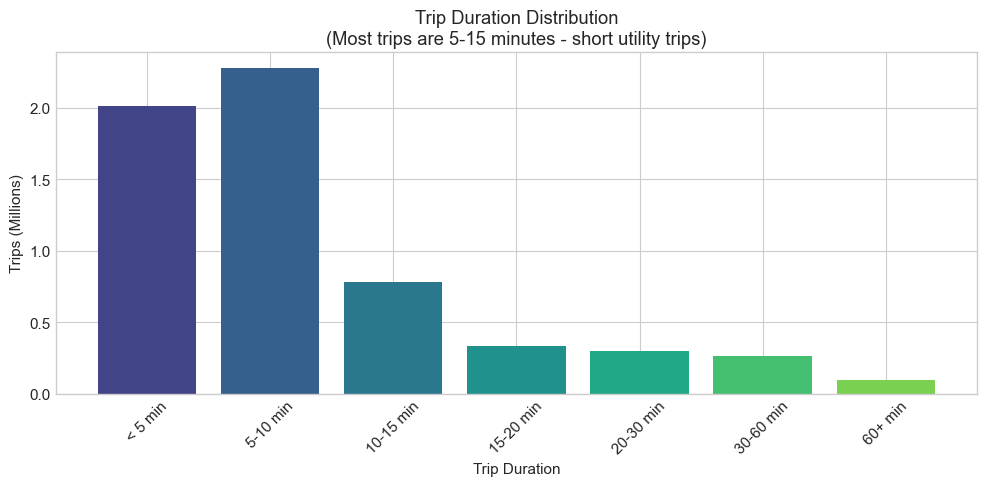

duration_bucket   trips   pct
        < 5 min 2010417 33.23
       5-10 min 2274433 37.60
      10-15 min  778708 12.87
      15-20 min  330381  5.46
      20-30 min  296957  4.91
      30-60 min  261125  4.32
        60+ min   97488  1.61


In [16]:
# Duration distribution
duration_dist = con.execute(f'''
    SELECT
        CASE 
            WHEN duration_sec < 300 THEN '< 5 min'
            WHEN duration_sec < 600 THEN '5-10 min'
            WHEN duration_sec < 900 THEN '10-15 min'
            WHEN duration_sec < 1200 THEN '15-20 min'
            WHEN duration_sec < 1800 THEN '20-30 min'
            WHEN duration_sec < 3600 THEN '30-60 min'
            ELSE '60+ min'
        END as duration_bucket,
        COUNT(*) as trips,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) as pct
    FROM "{JC_DATA}"
    GROUP BY 1
    ORDER BY 
        CASE duration_bucket
            WHEN '< 5 min' THEN 1
            WHEN '5-10 min' THEN 2
            WHEN '10-15 min' THEN 3
            WHEN '15-20 min' THEN 4
            WHEN '20-30 min' THEN 5
            WHEN '30-60 min' THEN 6
            ELSE 7
        END
''').fetchdf()

fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(duration_dist)))
ax.bar(duration_dist['duration_bucket'], duration_dist['trips'] / 1e6, color=colors)
ax.set_xlabel('Trip Duration')
ax.set_ylabel('Trips (Millions)')
ax.set_title('Trip Duration Distribution\n(Most trips are 5-15 minutes - short utility trips)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(duration_dist.to_string(index=False))

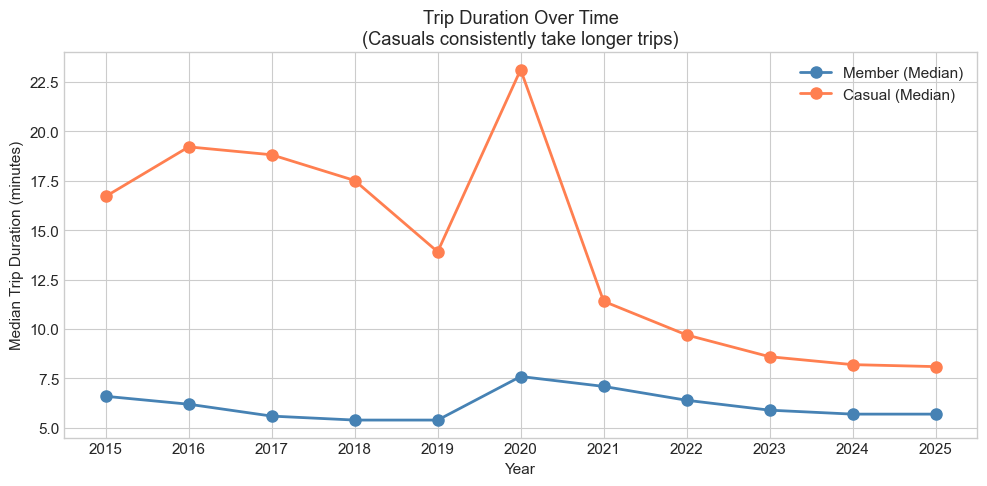

In [17]:
# Duration by user type over time
duration_trend = con.execute(f'''
    SELECT
        EXTRACT(YEAR FROM started_at) as year,
        member_casual,
        ROUND(AVG(duration_sec) / 60, 1) as avg_duration,
        ROUND(MEDIAN(duration_sec) / 60, 1) as median_duration
    FROM "{JC_DATA}"
    GROUP BY 1, 2
    ORDER BY 1, 2
''').fetchdf()

fig, ax = plt.subplots(figsize=(10, 5))

for user_type, color in [('member', 'steelblue'), ('casual', 'coral')]:
    data = duration_trend[duration_trend['member_casual'] == user_type]
    ax.plot(data['year'], data['median_duration'], 'o-', label=f'{user_type.title()} (Median)', 
            linewidth=2, markersize=8, color=color)

ax.set_xlabel('Year')
ax.set_ylabel('Median Trip Duration (minutes)')
ax.set_title('Trip Duration Over Time\n(Casuals consistently take longer trips)')
ax.legend()
ax.set_xticks(duration_trend['year'].unique())
plt.tight_layout()
plt.show()

---
## 8. Member vs Casual Deep Dive

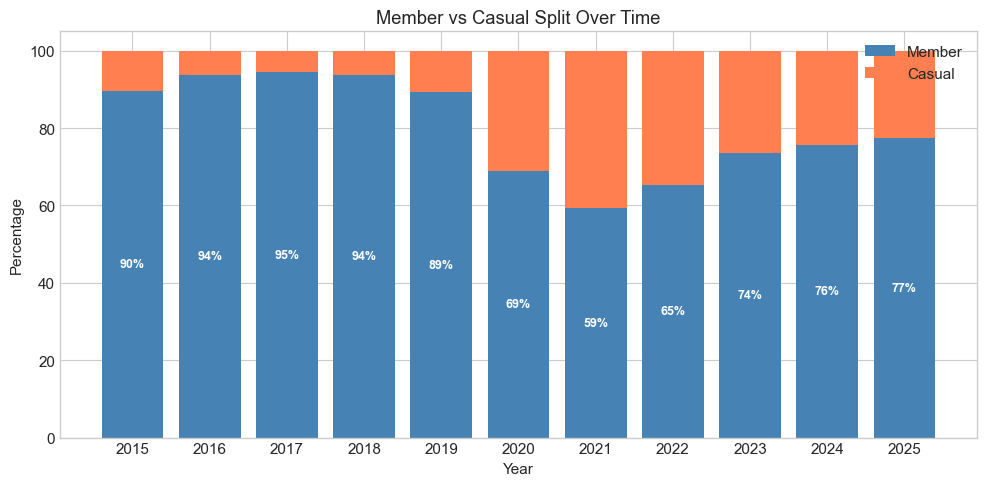

In [18]:
# Member vs Casual split over time
member_trend = con.execute(f'''
    SELECT
        EXTRACT(YEAR FROM started_at) as year,
        ROUND(100.0 * SUM(CASE WHEN member_casual = 'member' THEN 1 ELSE 0 END) / COUNT(*), 1) as member_pct,
        ROUND(100.0 * SUM(CASE WHEN member_casual = 'casual' THEN 1 ELSE 0 END) / COUNT(*), 1) as casual_pct
    FROM "{JC_DATA}"
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(member_trend['year'], member_trend['member_pct'], label='Member', color='steelblue')
ax.bar(member_trend['year'], member_trend['casual_pct'], bottom=member_trend['member_pct'], 
       label='Casual', color='coral')

ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Member vs Casual Split Over Time')
ax.legend(loc='upper right')
ax.set_xticks(member_trend['year'])
ax.set_ylim(0, 105)

# Annotate percentages
for i, (year, member_pct) in enumerate(zip(member_trend['year'], member_trend['member_pct'])):
    ax.annotate(f'{member_pct:.0f}%', xy=(year, member_pct/2), ha='center', va='center', 
                fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

In [19]:
# Behavioral differences
behavior = con.execute(f'''
    SELECT
        member_casual,
        COUNT(*) as trips,
        ROUND(AVG(duration_sec) / 60, 1) as avg_duration_min,
        ROUND(MEDIAN(duration_sec) / 60, 1) as median_duration_min,
        ROUND(100.0 * SUM(CASE WHEN start_station_name = end_station_name THEN 1 ELSE 0 END) / COUNT(*), 2) as round_trip_pct,
        ROUND(100.0 * SUM(CASE WHEN EXTRACT(DOW FROM started_at) IN (0, 6) THEN 1 ELSE 0 END) / COUNT(*), 1) as weekend_pct,
        ROUND(100.0 * SUM(CASE WHEN EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9 
                              OR EXTRACT(HOUR FROM started_at) BETWEEN 17 AND 19 THEN 1 ELSE 0 END) / COUNT(*), 1) as rush_hour_pct
    FROM "{JC_DATA}"
    GROUP BY 1
''').fetchdf()

print("\nMember vs Casual Behavioral Comparison:")
print("=" * 60)
print(behavior.T.to_string())
print("\nKey Insights:")
print("- Members: Shorter trips, more rush hour, more weekday = commuters")
print("- Casuals: Longer trips, more weekend, more round trips = leisure")


Member vs Casual Behavioral Comparison:
                         0        1        2
member_casual         None   casual   member
trips                  494  1462448  4586567
avg_duration_min      19.0     17.7      8.6
median_duration_min   14.4      9.9      5.9
round_trip_pct       12.96    11.91     3.48
weekend_pct           51.6     37.9     22.5
rush_hour_pct         28.5     36.1     47.1

Key Insights:
- Members: Shorter trips, more rush hour, more weekday = commuters
- Casuals: Longer trips, more weekend, more round trips = leisure


---
## 9. COVID Impact Analysis

In [20]:
# Pre/During/Post COVID comparison
covid = con.execute(f'''
    SELECT
        CASE 
            WHEN started_at < '2020-03-01' THEN 'Pre-COVID (2019)'
            WHEN started_at BETWEEN '2020-03-01' AND '2020-06-30' THEN 'Lockdown (Mar-Jun 2020)'
            WHEN started_at BETWEEN '2020-07-01' AND '2020-12-31' THEN 'Recovery (Jul-Dec 2020)'
            WHEN started_at >= '2021-01-01' AND started_at < '2022-01-01' THEN 'New Normal (2021)'
            ELSE 'Post-COVID (2022+)'
        END as period,
        COUNT(*) / COUNT(DISTINCT DATE(started_at)) as avg_daily_trips,
        ROUND(100.0 * SUM(CASE WHEN member_casual = 'member' THEN 1 ELSE 0 END) / COUNT(*), 1) as member_pct,
        ROUND(100.0 * SUM(CASE WHEN EXTRACT(DOW FROM started_at) IN (0, 6) THEN 1 ELSE 0 END) / COUNT(*), 1) as weekend_pct,
        ROUND(AVG(duration_sec) / 60, 1) as avg_duration
    FROM "{JC_DATA}"
    WHERE EXTRACT(YEAR FROM started_at) BETWEEN 2019 AND 2022
    GROUP BY 1
    ORDER BY 
        CASE period
            WHEN 'Pre-COVID (2019)' THEN 1
            WHEN 'Lockdown (Mar-Jun 2020)' THEN 2
            WHEN 'Recovery (Jul-Dec 2020)' THEN 3
            WHEN 'New Normal (2021)' THEN 4
            ELSE 5
        END
''').fetchdf()

print("COVID Period Comparison:")
print(covid.to_string(index=False))

COVID Period Comparison:
                 period  avg_daily_trips  member_pct  weekend_pct  avg_duration
       Pre-COVID (2019)      1054.752941        89.9         22.5           9.2
Lockdown (Mar-Jun 2020)       716.685950        61.6         37.2          25.0
Recovery (Jul-Dec 2020)      1001.666667        65.8         33.2          19.5
      New Normal (2021)      1701.835165        59.4         29.3          14.5
     Post-COVID (2022+)      2352.125341        65.4         28.5          12.0


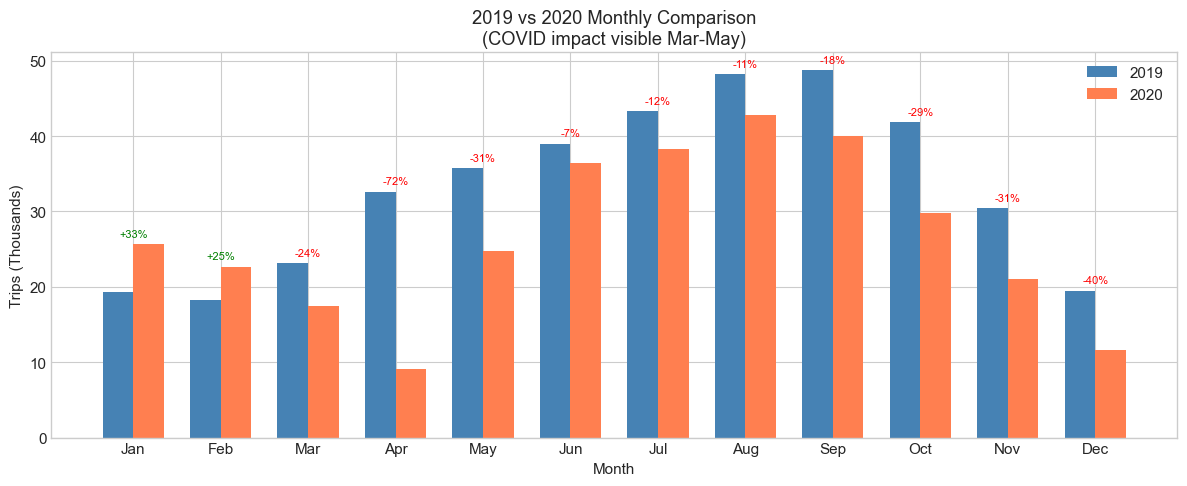

In [21]:
# 2019 vs 2020 same month comparison
yoy_covid = con.execute(f'''
    SELECT
        EXTRACT(MONTH FROM started_at) as month,
        SUM(CASE WHEN EXTRACT(YEAR FROM started_at) = 2019 THEN 1 ELSE 0 END) as trips_2019,
        SUM(CASE WHEN EXTRACT(YEAR FROM started_at) = 2020 THEN 1 ELSE 0 END) as trips_2020,
        ROUND(100.0 * (SUM(CASE WHEN EXTRACT(YEAR FROM started_at) = 2020 THEN 1 ELSE 0 END) - 
                       SUM(CASE WHEN EXTRACT(YEAR FROM started_at) = 2019 THEN 1 ELSE 0 END)) /
              NULLIF(SUM(CASE WHEN EXTRACT(YEAR FROM started_at) = 2019 THEN 1 ELSE 0 END), 0), 1) as yoy_change_pct
    FROM "{JC_DATA}"
    WHERE EXTRACT(YEAR FROM started_at) IN (2019, 2020)
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(12)
width = 0.35

ax.bar(x - width/2, yoy_covid['trips_2019'] / 1000, width, label='2019', color='steelblue')
ax.bar(x + width/2, yoy_covid['trips_2020'] / 1000, width, label='2020', color='coral')

ax.set_xlabel('Month')
ax.set_ylabel('Trips (Thousands)')
ax.set_title('2019 vs 2020 Monthly Comparison\n(COVID impact visible Mar-May)')
ax.set_xticks(x)
ax.set_xticklabels(month_names)
ax.legend()

# Annotate YoY change
for i, change in enumerate(yoy_covid['yoy_change_pct']):
    if pd.notna(change):
        color = 'green' if change > 0 else 'red'
        ax.annotate(f'{change:+.0f}%', xy=(i, max(yoy_covid['trips_2019'].iloc[i], yoy_covid['trips_2020'].iloc[i])/1000 + 1),
                    ha='center', fontsize=8, color=color)

plt.tight_layout()
plt.show()

---
## 10. JC vs NYC Comparison

In [22]:
# Compare JC to NYC
try:
    comparison = con.execute(f'''
        WITH jc AS (
            SELECT
                'Jersey City' as system,
                COUNT(*) as trips,
                COUNT(DISTINCT DATE(started_at)) as days,
                ROUND(AVG(duration_sec) / 60, 1) as avg_duration,
                ROUND(100.0 * SUM(CASE WHEN member_casual = 'member' THEN 1 ELSE 0 END) / COUNT(*), 1) as member_pct,
                ROUND(100.0 * SUM(CASE WHEN EXTRACT(DOW FROM started_at) IN (0, 6) THEN 1 ELSE 0 END) / COUNT(*), 1) as weekend_pct
            FROM "{JC_DATA}"
            WHERE EXTRACT(YEAR FROM started_at) = 2024
        ),
        nyc AS (
            SELECT
                'NYC' as system,
                COUNT(*) as trips,
                COUNT(DISTINCT DATE(started_at)) as days,
                ROUND(AVG(duration_sec) / 60, 1) as avg_duration,
                ROUND(100.0 * SUM(CASE WHEN member_casual = 'member' THEN 1 ELSE 0 END) / COUNT(*), 1) as member_pct,
                ROUND(100.0 * SUM(CASE WHEN EXTRACT(DOW FROM started_at) IN (0, 6) THEN 1 ELSE 0 END) / COUNT(*), 1) as weekend_pct
            FROM "{NYC_DATA}"
            WHERE EXTRACT(YEAR FROM started_at) = 2024
        )
        SELECT * FROM jc
        UNION ALL
        SELECT * FROM nyc
    ''').fetchdf()
    
    comparison['avg_daily_trips'] = comparison['trips'] / comparison['days']
    
    print("JC vs NYC Comparison (2024):")
    print("=" * 60)
    print(comparison.to_string(index=False))
    print(f"\nNYC is {comparison[comparison['system']=='NYC']['trips'].values[0] / comparison[comparison['system']=='Jersey City']['trips'].values[0]:.0f}x larger than JC")
except:
    print("NYC data not available for comparison")

JC vs NYC Comparison (2024):
     system    trips  days  avg_duration  member_pct  weekend_pct  avg_daily_trips
Jersey City  1026925   366           9.3        75.6         26.1      2805.806011
        NYC 43515161   366          12.7        80.6         26.1    118893.882514

NYC is 42x larger than JC


---
## 11. Station Growth Over Time

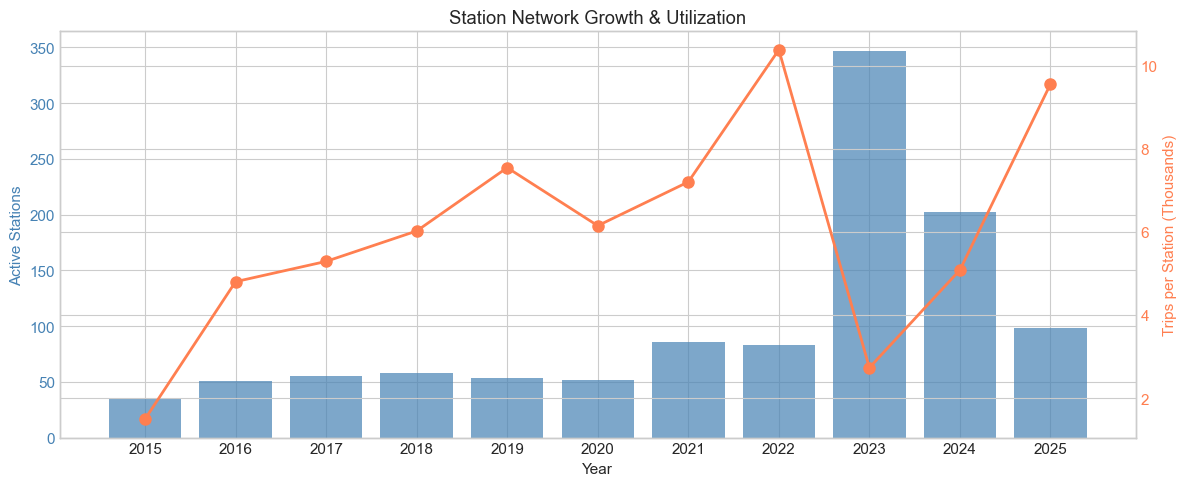

 year  active_stations   trips  trips_per_station
 2015               35   52275        1493.571429
 2016               51  244902        4802.000000
 2017               55  290951        5290.018182
 2018               58  349277        6022.017241
 2019               53  399939        7546.018868
 2020               52  319757        6149.173077
 2021               86  619468        7203.116279
 2022               83  861828       10383.469880
 2023              347  947571        2730.752161
 2024              202 1026925        5083.787129
 2025               98  936616        9557.306122


In [23]:
# Station count by year
station_growth = con.execute(f'''
    SELECT
        EXTRACT(YEAR FROM started_at) as year,
        COUNT(DISTINCT start_station_name) as active_stations,
        COUNT(*) as trips,
        COUNT(*) / COUNT(DISTINCT start_station_name) as trips_per_station
    FROM "{JC_DATA}"
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.bar(station_growth['year'], station_growth['active_stations'], color='steelblue', alpha=0.7, label='Active Stations')
ax1.set_xlabel('Year')
ax1.set_ylabel('Active Stations', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(station_growth['year'], station_growth['trips_per_station'] / 1000, 'o-', 
         color='coral', linewidth=2, markersize=8, label='Trips/Station (K)')
ax2.set_ylabel('Trips per Station (Thousands)', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')

ax1.set_title('Station Network Growth & Utilization')
ax1.set_xticks(station_growth['year'])

plt.tight_layout()
plt.show()

print(station_growth.to_string(index=False))

---
## 12. Interesting Anomalies & Findings

In [24]:
# Busiest single days
busiest_days = con.execute(f'''
    SELECT
        DATE(started_at) as date,
        DAYNAME(started_at) as day_name,
        COUNT(*) as trips
    FROM "{JC_DATA}"
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 10
''').fetchdf()

print("Top 10 Busiest Days:")
print(busiest_days.to_string(index=False))

Top 10 Busiest Days:
      date day_name  trips
2025-09-26   Friday   4684
2025-09-19   Friday   4475
2024-10-31 Thursday   4465
2024-06-08 Saturday   4440
2024-09-13   Friday   4430
2024-07-04 Thursday   4425
2024-09-21 Saturday   4416
2024-09-19 Thursday   4413
2024-09-20   Friday   4402
2022-09-17 Saturday   4396


In [25]:
# Slowest days (excluding early years with less data)
slowest_days = con.execute(f'''
    SELECT
        DATE(started_at) as date,
        DAYNAME(started_at) as day_name,
        COUNT(*) as trips
    FROM "{JC_DATA}"
    WHERE EXTRACT(YEAR FROM started_at) >= 2018
    GROUP BY 1, 2
    ORDER BY 3 ASC
    LIMIT 10
''').fetchdf()

print("Top 10 Slowest Days (2018+):")
print(slowest_days.to_string(index=False))
print("\n(Low days are typically major holidays, blizzards, or hurricane warnings)")

Top 10 Slowest Days (2018+):
      date  day_name  trips
2021-02-01    Monday      2
2020-12-17  Thursday      3
2021-02-07    Sunday     28
2021-02-03 Wednesday     37
2021-02-18  Thursday     46
2018-01-04  Thursday     50
2020-03-23    Monday     52
2021-02-19    Friday     70
2018-01-06  Saturday     75
2021-02-08    Monday     81

(Low days are typically major holidays, blizzards, or hurricane warnings)


In [26]:
# Night owl analysis - late night trips
night_owl = con.execute(f'''
    SELECT
        EXTRACT(YEAR FROM started_at) as year,
        COUNT(*) as total_trips,
        SUM(CASE WHEN EXTRACT(HOUR FROM started_at) BETWEEN 0 AND 4 THEN 1 ELSE 0 END) as late_night_trips,
        ROUND(100.0 * SUM(CASE WHEN EXTRACT(HOUR FROM started_at) BETWEEN 0 AND 4 THEN 1 ELSE 0 END) / COUNT(*), 2) as late_night_pct
    FROM "{JC_DATA}"
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

print("Late Night Trips (12am-4am):")
print(night_owl.to_string(index=False))
print("\n(Late night % tracks nightlife/bar scene activity)")

Late Night Trips (12am-4am):
 year  total_trips  late_night_trips  late_night_pct
 2015        52275            1186.0            2.27
 2016       244902            5648.0            2.31
 2017       290951            5617.0            1.93
 2018       349277            6124.0            1.75
 2019       399939            6813.0            1.70
 2020       319757            6864.0            2.15
 2021       619468           21220.0            3.43
 2022       861828           27880.0            3.23
 2023       947571           27311.0            2.88
 2024      1026925           28615.0            2.79
 2025       936616           26448.0            2.82

(Late night % tracks nightlife/bar scene activity)


In [27]:
# Longest trips in the dataset
longest = con.execute(f'''
    SELECT
        started_at,
        start_station_name,
        end_station_name,
        ROUND(duration_sec / 60.0, 1) as duration_min,
        member_casual
    FROM "{JC_DATA}"
    ORDER BY duration_sec DESC
    LIMIT 10
''').fetchdf()

print("Longest Trips (likely forgotten returns or errors):")
print(longest.to_string(index=False))

Longest Trips (likely forgotten returns or errors):
             started_at         start_station_name   end_station_name  duration_min member_casual
2023-04-10 16:00:00.000               Morris Canal   Essex Light Rail         240.0        casual
2019-07-27 15:41:45.150           Heights Elevator            York St         240.0        casual
2022-06-29 08:14:57.000            McGinley Square     Journal Square         240.0        casual
2018-06-03 16:08:36.173              Grove St PATH      Grove St PATH         239.9        casual
2018-08-24 12:10:32.408              Washington St        Dixon Mills         239.9        casual
2024-06-08 15:26:30.379    Bergen Ave & Stegman St Grant Ave & MLK Dr         239.9        casual
2021-11-17 12:27:10.000           Heights Elevator   Grand St & 14 St         239.9        casual
2016-10-30 11:30:20.000               Newport Pkwy       Newport Pkwy         239.8        casual
2025-04-22 18:17:52.998    Bergen Ave & Stegman St      Montgomery

---
## 13. Geographic Clusters

In [28]:
# Interactive map with Folium
station_coords = con.execute(f'''
    SELECT
        start_station_name as station,
        ROUND(AVG(start_lat), 5) as lat,
        ROUND(AVG(start_lon), 5) as lon,
        COUNT(*) as trips,
        ROUND(100.0 * SUM(CASE WHEN member_casual = 'member' THEN 1 ELSE 0 END) / COUNT(*), 1) as member_pct
    FROM "{JC_DATA}"
    WHERE start_lat IS NOT NULL AND start_lon IS NOT NULL
      AND start_lat BETWEEN 40.68 AND 40.78
      AND start_lon BETWEEN -74.12 AND -74.01
    GROUP BY 1
    HAVING COUNT(*) > 500
    ORDER BY 4 DESC
''').fetchdf()

# Create map centered on JC/Hoboken
center_lat = station_coords['lat'].mean()
center_lon = station_coords['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles='CartoDB positron')

# Color scale based on trip volume
max_trips = station_coords['trips'].max()

for _, row in station_coords.iterrows():
    # Size based on trips (radius 5-25)
    radius = 5 + (row['trips'] / max_trips) * 20
    
    # Color based on member percentage (blue=high member, red=low member)
    if row['member_pct'] >= 80:
        color = '#1f77b4'  # Blue - commuter heavy
    elif row['member_pct'] >= 60:
        color = '#2ca02c'  # Green - mixed
    else:
        color = '#ff7f0e'  # Orange - casual heavy
    
    popup_text = f"""
    <b>{row['station']}</b><br>
    Trips: {row['trips']:,}<br>
    Member %: {row['member_pct']:.1f}%
    """
    
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=radius,
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.6,
        popup=folium.Popup(popup_text, max_width=200),
        tooltip=row['station']
    ).add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; 
            background-color: white; padding: 10px; border-radius: 5px;
            border: 2px solid grey; font-size: 12px;">
<b>Station Types</b><br>
<i style="background:#1f77b4; width:12px; height:12px; display:inline-block; border-radius:50%;"></i> Commuter (80%+ members)<br>
<i style="background:#2ca02c; width:12px; height:12px; display:inline-block; border-radius:50%;"></i> Mixed (60-80% members)<br>
<i style="background:#ff7f0e; width:12px; height:12px; display:inline-block; border-radius:50%;"></i> Casual-heavy (<60% members)<br>
<br><b>Size = Trip Volume</b>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

print(f"Interactive map with {len(station_coords)} stations")
print("Click on stations for details!")
m

Interactive map with 104 stations
Click on stations for details!


---
## 14. Summary Statistics

In [29]:
# Final summary
print("=" * 70)
print("JERSEY CITY CITI BIKE - SUMMARY")
print("=" * 70)

summary = con.execute(f'''
    SELECT
        COUNT(*) as total_trips,
        MIN(DATE(started_at)) as first_date,
        MAX(DATE(started_at)) as last_date,
        COUNT(DISTINCT DATE(started_at)) as days_of_data,
        COUNT(*) / COUNT(DISTINCT DATE(started_at)) as avg_daily_trips,
        COUNT(DISTINCT start_station_name) as unique_stations,
        ROUND(AVG(duration_sec) / 60, 1) as avg_duration_min,
        ROUND(MEDIAN(duration_sec) / 60, 1) as median_duration_min,
        ROUND(100.0 * SUM(CASE WHEN member_casual = 'member' THEN 1 ELSE 0 END) / COUNT(*), 1) as member_pct,
        ROUND(100.0 * SUM(CASE WHEN start_station_name = end_station_name THEN 1 ELSE 0 END) / COUNT(*), 2) as round_trip_pct
    FROM "{JC_DATA}"
''').fetchone()

print(f"""
Total Trips:              {summary[0]:,}
Date Range:               {summary[1]} to {summary[2]}
Days of Data:             {summary[3]:,}
Average Daily Trips:      {summary[4]:,.0f}
Unique Stations:          {summary[5]}
Avg Trip Duration:        {summary[6]} minutes
Median Trip Duration:     {summary[7]} minutes
Member Percentage:        {summary[8]}%
Round Trip Percentage:    {summary[9]}%
""")

print("KEY FINDINGS:")
print("-" * 70)
print("""
1. GROWTH: 20x growth from 2015 (52K) to 2024 (1M+) trips

2. COMMUTER FOCUSED: 75%+ members, clear AM/PM rush hour peaks on weekdays

3. PATH INTEGRATION: Grove St PATH and Exchange Pl are top stations - 
   bike share serves as first/last mile for NYC commuters

4. COVID IMPACT: Apr 2020 saw 75% drop, but recovered to exceed 2019 by summer 2021

5. SEASONALITY: 3x more trips in summer vs winter (Sep peak, Feb trough)

6. CASUAL BEHAVIOR: Longer trips (15 min vs 9 min), more weekends, more round trips

7. GEOGRAPHY: Concentrated along Hudson waterfront from Exchange Pl to Hoboken

8. CROSS-HUDSON: ~7,300 trips cross the Hudson River (via PATH/Ferry) to NYC!
""")

print("\nDATA QUALITY NOTE:")
print("-" * 70)
print("""
JC data receives the SAME quality filtering as NYC data:
- Duration filter: 90 seconds to 4 hours (removes errors/lost bikes)
- Test station filter: Removes depot, mobile, test stations
- Date validation: Parsed dates match expected month from filename
- Deduplication: Split files removed to prevent double-counting
""")

JERSEY CITY CITI BIKE - SUMMARY

Total Trips:              6,049,509
Date Range:               2015-09-21 to 2025-11-30
Days of Data:             3,715
Average Daily Trips:      1,628
Unique Stations:          454
Avg Trip Duration:        10.8 minutes
Median Trip Duration:     6.7 minutes
Member Percentage:        75.8%
Round Trip Percentage:    5.52%

KEY FINDINGS:
----------------------------------------------------------------------

1. GROWTH: 20x growth from 2015 (52K) to 2024 (1M+) trips

2. COMMUTER FOCUSED: 75%+ members, clear AM/PM rush hour peaks on weekdays

3. PATH INTEGRATION: Grove St PATH and Exchange Pl are top stations - 
   bike share serves as first/last mile for NYC commuters

4. COVID IMPACT: Apr 2020 saw 75% drop, but recovered to exceed 2019 by summer 2021

5. SEASONALITY: 3x more trips in summer vs winter (Sep peak, Feb trough)

6. CASUAL BEHAVIOR: Longer trips (15 min vs 9 min), more weekends, more round trips

7. GEOGRAPHY: Concentrated along Hudson waterfron

---
## 15. Cross-Hudson Trips: Bikes Across the River!

One of the most interesting aspects of the JC system: people actually take bikes across the Hudson to NYC!

**How is this possible?**
- **PATH Train**: Bikes allowed on PATH (off-peak hours) - Grove St, Exchange Pl, Hoboken Terminal
- **NY Waterway Ferry**: Bikes allowed on ferries from Hoboken/JC to Manhattan
- **George Washington Bridge**: Bike path across the GW Bridge (northern trips)

Let's analyze these cross-river adventurers!

In [30]:
# Cross-Hudson trip analysis
# JC/Hoboken is west of -74.01 longitude, Manhattan is east of -74.01

cross_hudson_stats = con.execute(f'''
    WITH cross_hudson AS (
        SELECT *,
            CASE 
                WHEN start_lon < -74.01 AND end_lon > -74.01 THEN 'JC to NYC'
                WHEN start_lon > -74.01 AND end_lon < -74.01 THEN 'NYC to JC'
                ELSE 'Within Region'
            END as trip_direction
        FROM "{JC_DATA}"
        WHERE start_lon IS NOT NULL AND end_lon IS NOT NULL
    )
    SELECT
        trip_direction,
        COUNT(*) as trips,
        ROUND(AVG(duration_sec) / 60, 1) as avg_duration_min,
        ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY duration_sec) / 60, 1) as median_duration_min,
        ROUND(100.0 * SUM(CASE WHEN member_casual = 'member' THEN 1 ELSE 0 END) / COUNT(*), 1) as member_pct
    FROM cross_hudson
    WHERE trip_direction != 'Within Region'
    GROUP BY 1
    ORDER BY 2 DESC
''').fetchdf()

print("=" * 60)
print("CROSS-HUDSON TRIPS: Bikes Across the River!")
print("=" * 60)
print(cross_hudson_stats.to_string(index=False))

total_cross = cross_hudson_stats['trips'].sum()
print(f"\nTotal cross-Hudson trips: {total_cross:,}")
print(f"Average duration: ~{cross_hudson_stats['avg_duration_min'].mean():.0f} minutes")
print("\nThese trips likely involve PATH train or NY Waterway Ferry!")

CROSS-HUDSON TRIPS: Bikes Across the River!
trip_direction  trips  avg_duration_min  median_duration_min  member_pct
     JC to NYC   7349              37.6                 28.4        82.1
     NYC to JC      1              24.2                 24.2       100.0

Total cross-Hudson trips: 7,350
Average duration: ~31 minutes

These trips likely involve PATH train or NY Waterway Ferry!


In [31]:
# Where do cross-Hudson trips go in NYC?
nyc_destinations = con.execute(f'''
    SELECT
        end_station_name as nyc_station,
        ROUND(end_lat, 4) as lat,
        ROUND(end_lon, 4) as lon,
        COUNT(*) as trips,
        ROUND(AVG(duration_sec) / 60, 1) as avg_duration_min
    FROM "{JC_DATA}"
    WHERE start_lon < -74.01 AND end_lon > -74.01  -- JC to NYC
      AND end_station_name IS NOT NULL
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
    LIMIT 15
''').fetchdf()

print("Top NYC Destinations (from JC/Hoboken):")
print("=" * 60)
print(nyc_destinations.to_string(index=False))
print("\nNote: These are mostly Lower Manhattan stations near ferry terminals!")

Top NYC Destinations (from JC/Hoboken):
             nyc_station     lat      lon  trips  avg_duration_min
        12 Ave & W 40 St 40.7609 -74.0028    306              44.6
        10 Ave & W 14 St 40.7420 -74.0083    169              29.1
Lafayette St & Jersey St 40.7246 -73.9957    169              22.3
Pier 61 at Chelsea Piers 40.7469 -74.0082    144              29.2
    Maiden Ln & Pearl St 40.7071 -74.0073    141              25.8
         8 Ave & W 16 St 40.7410 -74.0017    138              25.4
   Mercer St & Spring St 40.7236 -73.9995    137              22.7
         E 40 St & 5 Ave 40.7521 -73.9816    131              20.4
      E 40 St & Park Ave 40.7508 -73.9783    125              29.4
         W 44 St & 5 Ave 40.7550 -73.9801    115              24.6
        W 30 St & 10 Ave 40.7527 -74.0024    109              34.7
 W 34 St & Hudson Blvd E 40.7552 -74.0006    107              28.2
    Fulton St & Broadway 40.7111 -74.0094    104              29.1
        W 34 St & 11 A

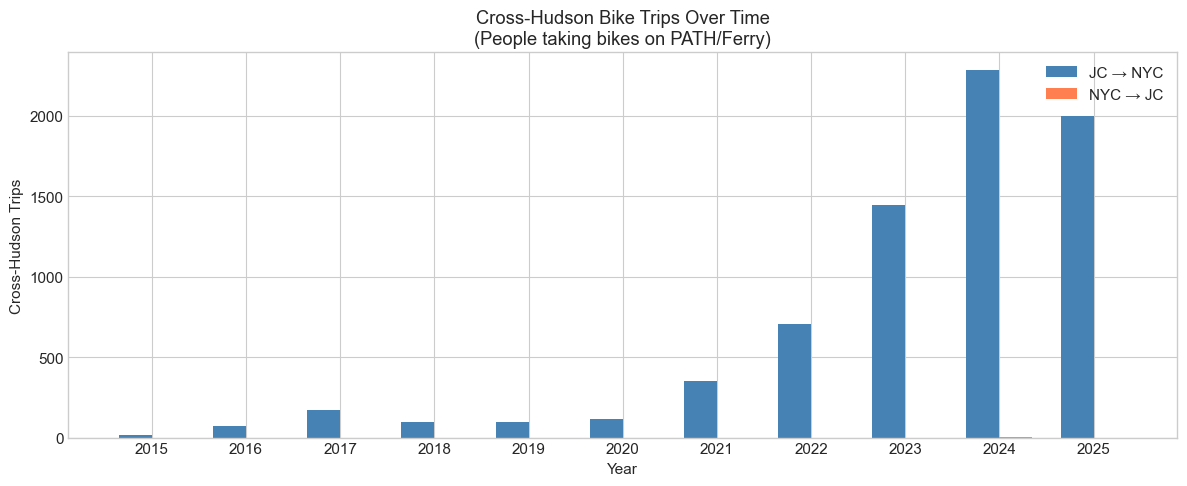


Cross-Hudson Trip Counts by Year:
 year  jc_to_nyc  nyc_to_jc  total_cross_hudson
 2015       14.0        0.0                14.0
 2016       69.0        0.0                69.0
 2017      173.0        0.0               173.0
 2018       94.0        0.0                94.0
 2019       97.0        0.0                97.0
 2020      116.0        0.0               116.0
 2021      352.0        0.0               352.0
 2022      704.0        0.0               704.0
 2023     1448.0        0.0              1448.0
 2024     2281.0        1.0              2282.0
 2025     2001.0        0.0              2001.0


In [32]:
# Cross-Hudson trips over time
cross_hudson_trend = con.execute(f'''
    SELECT
        EXTRACT(YEAR FROM started_at) as year,
        SUM(CASE WHEN start_lon < -74.01 AND end_lon > -74.01 THEN 1 ELSE 0 END) as jc_to_nyc,
        SUM(CASE WHEN start_lon > -74.01 AND end_lon < -74.01 THEN 1 ELSE 0 END) as nyc_to_jc,
        SUM(CASE WHEN (start_lon < -74.01 AND end_lon > -74.01) 
                  OR (start_lon > -74.01 AND end_lon < -74.01) THEN 1 ELSE 0 END) as total_cross_hudson
    FROM "{JC_DATA}"
    WHERE start_lon IS NOT NULL AND end_lon IS NOT NULL
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

fig, ax = plt.subplots(figsize=(12, 5))

x = cross_hudson_trend['year']
width = 0.35

ax.bar(x - width/2, cross_hudson_trend['jc_to_nyc'], width, label='JC → NYC', color='steelblue')
ax.bar(x + width/2, cross_hudson_trend['nyc_to_jc'], width, label='NYC → JC', color='coral')

ax.set_xlabel('Year')
ax.set_ylabel('Cross-Hudson Trips')
ax.set_title('Cross-Hudson Bike Trips Over Time\n(People taking bikes on PATH/Ferry)')
ax.legend()
ax.set_xticks(x)

plt.tight_layout()
plt.show()

print("\nCross-Hudson Trip Counts by Year:")
print(cross_hudson_trend.to_string(index=False))

In [33]:
# Interactive map showing cross-Hudson flows
# Get top JC origins and NYC destinations for cross-Hudson trips

cross_hudson_routes = con.execute(f'''
    SELECT
        start_station_name as jc_origin,
        ROUND(AVG(start_lat), 5) as origin_lat,
        ROUND(AVG(start_lon), 5) as origin_lon,
        end_station_name as nyc_dest,
        ROUND(AVG(end_lat), 5) as dest_lat,
        ROUND(AVG(end_lon), 5) as dest_lon,
        COUNT(*) as trips
    FROM "{JC_DATA}"
    WHERE start_lon < -74.01 AND end_lon > -74.01  -- JC to NYC only
      AND start_station_name IS NOT NULL 
      AND end_station_name IS NOT NULL
    GROUP BY 1, 4
    ORDER BY trips DESC
    LIMIT 20
''').fetchdf()

# Create a wider map to show both sides of the Hudson
m2 = folium.Map(location=[40.73, -74.01], zoom_start=12, tiles='CartoDB positron')

# Draw lines for top routes
for _, row in cross_hudson_routes.iterrows():
    # Line from JC to NYC
    folium.PolyLine(
        locations=[[row['origin_lat'], row['origin_lon']], 
                   [row['dest_lat'], row['dest_lon']]],
        weight=max(1, row['trips'] / 20),  # Line thickness by volume
        color='#e74c3c',
        opacity=0.6,
        popup=f"{row['jc_origin']} → {row['nyc_dest']}: {row['trips']} trips"
    ).add_to(m2)

# Add JC origin markers
jc_origins = cross_hudson_routes.groupby(['jc_origin', 'origin_lat', 'origin_lon'])['trips'].sum().reset_index()
for _, row in jc_origins.iterrows():
    folium.CircleMarker(
        location=[row['origin_lat'], row['origin_lon']],
        radius=8,
        color='blue',
        fill=True,
        fillOpacity=0.7,
        popup=f"JC: {row['jc_origin']}<br>{row['trips']} cross-Hudson trips",
        tooltip=row['jc_origin']
    ).add_to(m2)

# Add NYC destination markers  
nyc_dests = cross_hudson_routes.groupby(['nyc_dest', 'dest_lat', 'dest_lon'])['trips'].sum().reset_index()
for _, row in nyc_dests.iterrows():
    folium.CircleMarker(
        location=[row['dest_lat'], row['dest_lon']],
        radius=8,
        color='green',
        fill=True,
        fillOpacity=0.7,
        popup=f"NYC: {row['nyc_dest']}<br>{row['trips']} cross-Hudson trips",
        tooltip=row['nyc_dest']
    ).add_to(m2)

# Add legend
legend_html2 = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; 
            background-color: white; padding: 10px; border-radius: 5px;
            border: 2px solid grey; font-size: 12px;">
<b>Cross-Hudson Routes</b><br>
<i style="background:blue; width:12px; height:12px; display:inline-block; border-radius:50%;"></i> JC/Hoboken Origins<br>
<i style="background:green; width:12px; height:12px; display:inline-block; border-radius:50%;"></i> NYC Destinations<br>
<i style="background:#e74c3c; width:12px; height:4px; display:inline-block;"></i> Route (thickness = volume)
</div>
'''
m2.get_root().html.add_child(folium.Element(legend_html2))

print("Top 20 Cross-Hudson Routes (JC → NYC)")
print("Blue = JC origins, Green = NYC destinations")
print("Click markers for details!")
m2

Top 20 Cross-Hudson Routes (JC → NYC)
Blue = JC origins, Green = NYC destinations
Click markers for details!


In [34]:
# Close connection
con.close()
print("Analysis complete!")

Analysis complete!
